In [1]:
# MOUNTING THE DRIVE 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername of the unzipped folder
FOLDERNAME = 'unet-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/unet-master


In [3]:
pip install plantcv

     |████████████████████████████████| 222 kB 4.0 MB/s 
     |████████████████████████████████| 40 kB 4.1 MB/s 
     |████████████████████████████████| 47.9 MB 12 kB/s 
     |████████████████████████████████| 766 kB 34.1 MB/s 
     |████████████████████████████████| 984 kB 20.6 MB/s 
     |████████████████████████████████| 118 kB 55.5 MB/s 
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0
  Attempting uninstall: distributed
    Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstal

In [4]:
from skimage import data, io, filters, morphology, color
from skimage.util import invert
from skimage.measure import label
from skimage.color import label2rgb
from skimage.metrics import adapted_rand_error
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import convolve
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
from plantcv import plantcv as pcv

In [5]:
n = 5
w = 256
test_dir = 'data/morpho_test/'
original = mpimg.imread(f'{test_dir}{n}_original.png')
trace =  mpimg.imread(f'{test_dir}{n}_tracing.png') 
gen = mpimg.imread(f'{test_dir}{w}_processed.png')

In [4]:
# Ignore this Cell!

'''
# Clean up the tracing
image = color.rgb2gray(color.rgba2rgb(trace))

thresh = 100/255 #It was already 0-1 scale with pixels at 0.999 smhh
threshold = np.zeros(image.shape)
threshold[image >= thresh] = 1

skeleton = morphology.skeletonize(threshold)
skel = 255 * skeleton
io.imsave(f'{test_dir}{n}_tracing.png', skel.astype('uint8')) 
plt.imshow(skel, cmap='gray')
print('The processed tracing should appear below. It will be very very faint')

#np.amax(image)
'''

"\n# Clean up the tracing\nimage = color.rgb2gray(color.rgba2rgb(trace))\n\nthresh = 100/255 #It was already 0-1 scale with pixels at 0.999 smhh\nthreshold = np.zeros(image.shape)\nthreshold[image >= thresh] = 1\n\nskeleton = morphology.skeletonize(threshold)\nskel = 255 * skeleton\nio.imsave(f'{test_dir}{n}_tracing.png', skel.astype('uint8')) \nplt.imshow(skel, cmap='gray')\nprint('The processed tracing should appear below. It will be very very faint')\n\n#np.amax(image)\n"

In [5]:
# Let's create Trace 256

gen = mpimg.imread(f'{test_dir}{w}_processed.png')
trace = mpimg.imread(f'{test_dir}{n}_tracing.png')

image_resized = resize(trace, (gen.shape[0],gen.shape[1]), anti_aliasing=True)
#Re Thresh Skeletonize
threshold = np.zeros(image_resized.shape)
threshold[image_resized > 0] = 1
skeleton = morphology.skeletonize(threshold)
skel = 255 * skeleton
io.imsave(f'{test_dir}{w}_tracing.png', skel.astype('uint8')) 
trace = skel

In [6]:
#Quickly create a visualization tool:
#original = gen
#new = floater_removed

def chop_view(original,new):
  #The new image is the original with some features cut off. This function
  #will let you view the chopped off features in comparison to the original
  original_rgb = color.gray2rgb(original)

  if np.amax(new) > 1:
    new = new/255
  new_rgb = color.gray2rgb(new)

  chopped = original_rgb - new_rgb
  #Kind of a trashy fix (turn off green and blu channels) but I dont know how to do it better
  chopped[:,:,1]=np.zeros((chopped.shape[0],chopped.shape[1]))
  chopped[:,:,2]=np.zeros((chopped.shape[0],chopped.shape[1]))

  return new_rgb+chopped

#plt.imshow(chop_view(gen,floater_removed))

In [7]:
#Remove the floaters

# NO NEED to crop the edges this time since we only care bout the boundaries anyways
#The boundary net will be sectioned up into connected branches, and all those shorter than some minimum length minlen will be destroyed

def remove_floaters(im,minlen):
  #Break up net into sections
  label_image = label(gen, connectivity = 2)

  #Count the number of pixels in each section
  unique_elements, counts_elements = np.unique(label_image, return_counts=True)
  #print("Frequency of unique values of the said array:")
  freq = np.asarray((unique_elements, counts_elements))
  #print(freq)
  
  #Keep ONLY any branches > some floater threshold (minlen) Depends on the image
  #Del_list will store the branches to remove
  del_list = []
  for row in freq.T:
    if row[1] < minlen:
      del_list.append(row[0])
  del_list

  floater_removed = np.copy(label_image)
  #Remove the designated branches
  for del_val in del_list:
    floater_removed[floater_removed == del_val] = 0

  return floater_removed

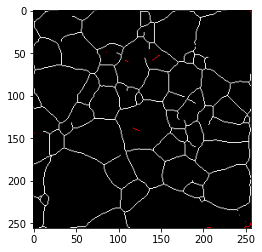

In [8]:
floater_removed = remove_floaters(gen,40)
plt.imshow(chop_view(gen,floater_removed))
#It's good!!

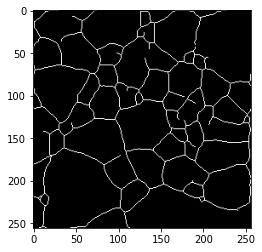

In [9]:
#We are done with labels time to go back to the binary
binarized = np.copy(floater_removed)
binarized[binarized>0.5] = 1
plt.imshow(floater_removed,cmap='gray') 

In [64]:
#Prune away short spurs

# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = None

# Remove all spurs below length size
size = 7
skeleton = pcv.morphology.skeletonize(mask=binarized)
pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skeleton, size)

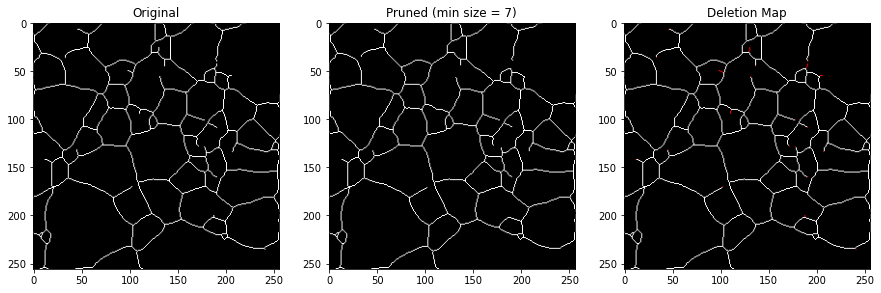

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize = (15,5))       

ax1.imshow(binarized, cmap='gray')
ax1.set_title('Original')
ax2.imshow(pruned_skeleton, cmap='gray')
ax2.set_title(f'Pruned (min size = {size})')
ax3.imshow(chop_view(binarized,pruned_skeleton))
ax3.set_title('Deletion Map')
plt.show()

In [78]:
s = 1/math.sqrt(2)
key = np.array([
                [(-s,-s),(0,-1),(s,-s)],
                [(-1,0),(0,0),(1,0)],
                [(-s,s),(0,1),(s,s)], 
              ])
key

array([[[-0.70710678, -0.70710678],
        [ 0.        , -1.        ],
        [ 0.70710678, -0.70710678]],

       [[-1.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 1.        ,  0.        ]],

       [[-0.70710678,  0.70710678],
        [ 0.        ,  1.        ],
        [ 0.70710678,  0.70710678]]])

In [12]:
plt.imshow(singletons)

NameError: ignored

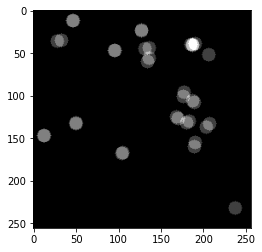

In [88]:
#Anisotropic Circle Placement (put it near one end)

#reservoir: singletons, tester

def generate_circles(im,singletons,radius,inset):
  #define set into circle fraction (0 = original no anisotropy, 1 = fully places at end of circle)
  q = 1-inset

  #Draw a circular stamp
  r = radius
  d = 2*r+1
  y,x = np.ogrid[-r: r+1, -r: r+1]
  mask = x**2+y**2 <= r**2

  s = 1/math.sqrt(2)
  keychain = np.array([
                  [(-s,-s),(0,-1),(s,-s)],
                  [(-1,0),(0,0),(1,0)],
                  [(-s,s),(0,1),(s,s)], 
                ])
  #keychain = -keychain #Flip the keys for correct direction

  #Add circular masks to a blank map using singletons as the positions
  circles = np.zeros((singletons.shape[0],singletons.shape[1]))
  for (x,y), value in np.ndenumerate(singletons):
    if value == 1:
      #print((x,y))

      diam = mask.shape[0]
      rad = round(diam/2)    
      
      #First determine the position of the nearest neighbor
      locx = 0
      locy = 0 
      
      #Simply enumerate thru the matrix of the kernel centered at the pixel
      for (i,j), val in np.ndenumerate(im[x-1:x+2,y-1:y+2]):
        if val == 1:
          locx = i
          locy = j
      #print(x,y)
      
      #Position is not the relative position of the white pixel to the singleton,
      #but rather it is the matrix position in which you'd find the white pixel
      #given the singleton is placed in the center of the 3x3 kernel matrix
      #print(position)
      key = keychain[locx,locy] #determine neighbor position and insert it here
      #print(key)
      xoff, yoff = key
      h = -rad + round(rad*q*xoff)
      k = -rad + round(rad*q*yoff) 
      
      if x+h >= 0 and y+k >= 0 and x+h+diam <= circles.shape[0] and y+h+diam <= circles.shape[1]: 
      #do not try to put circles in negative pixel places (beyond a radius and the inset frac)
        circles[x+h:x+h+diam, y+k:y+k+diam] += mask
  return circles
  
tester = np.around(pruned_skeleton/255)
singletons = mpimg.imread(f'{test_dir}singletons.png')

circles = generate_circles(tester,singletons,8,0.4)
plt.imshow(circles,cmap='gray')


In [114]:
tester = np.around(pruned_skeleton/255)
x = 101
y = 176

W = 
sector = tester[x-W:x+W+1,y-W:y+W+1]
sector

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

Frequency of unique values of the said array:
[[0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00]
 [6.2621e+04 1.4000e+01 2.4490e+03 2.9000e+02 6.5000e+01 9.7000e+01]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
endpoints: 14


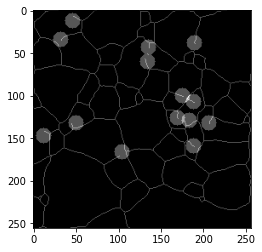

In [102]:
#Now, the algorithm to close the gap

#io.imsave(f'{test_dir}pruned_skeleton.png', pruned_skeleton.astype('uint8')) 

def close_gaps(im,radius,inset):
  rescaled = np.around(im/255) #im comes in in grayscale 0-255 so we must rescale to 0-1 like binarized

  #By convolving a ring shaped kernel on each pixel I get the number of neighbors for each pixel
  kernel = np.ones((3, 3))
  kernel[1, 1] = 0
  neighborcount = convolve(rescaled, kernel, mode="reflect")

  #However, black pixels with white in the neighborhood will also get counted,
  #So I will refer to the original binarized and REMOVE all background pixels
  neighborcount[rescaled == 0] = 0

  unique_elements, counts_elements = np.unique(neighborcount, return_counts=True)
  print("Frequency of unique values of the said array:")
  freq = np.asarray((unique_elements, counts_elements))
  print(freq)

  #Make a map of only the endpoints (pixels with one neighbor)
  singletons = np.copy(neighborcount)
  singletons[singletons != 1] = 0
  
  true_endpoints = np.logical_and(singletons,rescaled)
  true_endpoints = true_endpoints.astype(int)
  print(true_endpoints)
  plt.imshow(true_endpoints,cmap='gray')
  print('endpoints:',(true_endpoints == 1).sum())

  plt.imshow(singletons,cmap='gray')
  #io.imsave(f'{test_dir}singletons.png', singletons) 

  '''
  #Draw a circular stamp with radius radius
  r = radius
  d = 2*r+1
  y,x = np.ogrid[-r: r+1, -r: r+1]
  mask = x**2+y**2 <= r**2

  #Add circular masks to a blank map using singletons as the positions
  circles = np.zeros((singletons.shape[0],singletons.shape[1]))
  for (x,y), value in np.ndenumerate(singletons):
    if value == 1:
      diam = mask.shape[0]
      rad = round(diam/2)
      if x-rad > 0: #do not try to put circles in negative pixel places
        circles[x-rad:x-rad+diam, y-rad:y-rad+diam] += mask
  plt.imshow(circles,cmap='gray')
  '''
  circles = generate_circles(rescaled,true_endpoints,radius,inset) #singletons
  #plt.imshow(circles,cmap='gray')

  #Place the circles onto the map
  combine = rescaled + circles
  plt.imshow(combine,cmap = 'gray')

  #Finally, thresh and skeleton to get the fixed
  threshold = np.zeros(combine.shape)
  threshold[combine > 0] = 1
  skeleton = morphology.skeletonize(threshold)
  skel = 255 * skeleton
  return skel

skel = close_gaps(pruned_skeleton,9,0.4)
io.imsave(f'{test_dir}fixed_40-7-9-0.4.png', skel.astype('uint8')) 
#plt.imshow(skel,cmap='gray')
fixed = skel

In [197]:
def labelmake(S):
  inverted = invert(S)

  # Remove the border (1% on each side), which contains disconnects
  b = round(w*1/100)
  cropped = inverted[b:w-b,b:w-b]

  label_image = label(cropped, connectivity = 1)
  return label_image

ground_truth = labelmake(trace) 
comparison_unclean = labelmake(gen)
comparison_clean = labelmake(fixed)

from chi2test import *

chi2 = find_chi2(trace,gen)
chi2fixed = find_chi2(trace,fixed)

randerr,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_unclean, ignore_labels=[0])
print(f'the processed rand error is {randerr}\n its chi2 is {chi2}')
randerr_fixed,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_clean, ignore_labels=[0])
print(f'the floater&spur removed plus connection rand error is {randerr_fixed}\n its chi2 is {chi2fixed}')


the processed rand error is 0.16241893820030306
 its chi2 is 10033
the floater&spur removed plus connection rand error is 0.06184999564069282
 its chi2 is 11851


In [26]:
from randerr import *

#w = trace.shape[0]
randerr = find_randerr(trace,gen)

NameError: ignored

In [33]:
'''
This file contains the necessary functions to find the rand err
between two binarized skeletonized images of the same size.
Simply perform:

err = randerr(first,second)
where first and second are just the images in question.
'''

import numpy as np
from skimage.util import invert
from skimage.measure import label
from skimage.metrics import adapted_rand_error

def labelmake(S):
    inverted = invert(S)

    # Remove the border (1% on each side), which contains disconnects
    s = S.shape[0]
    b = round(s*1/100)
    cropped = inverted[b:s-b,b:s-b]

    label_image = label(cropped, connectivity = 1)
    return label_image

def find_randerr(first,second):
    first_label = labelmake(first) 
    second_label = labelmake(second)
    randerr,p,r = adapted_rand_error(image_true=first, image_test=second, ignore_labels=[0])
    return randerr


In [37]:
err = find_randerr(gen,trace)

TypeError: ignored

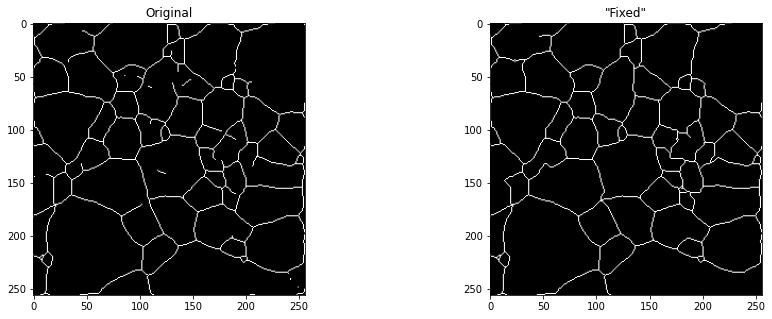

In [103]:

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize = (15,5))       

ax1.imshow(gen, cmap='gray')
ax1.set_title('Original')
ax2.imshow(fixed, cmap='gray')
ax2.set_title('\"Fixed\"')
plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type bool to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


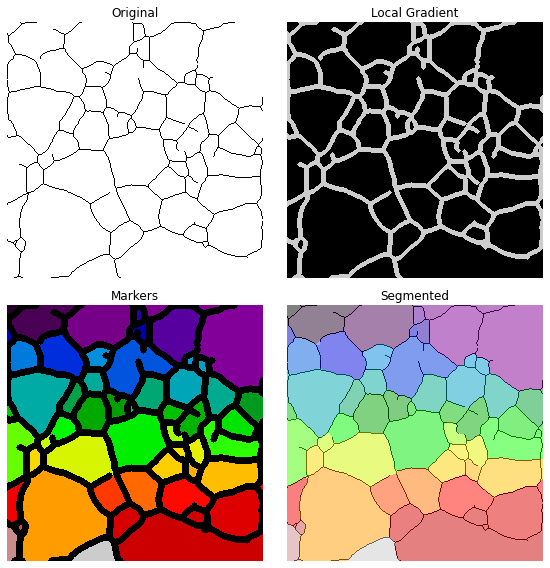

In [181]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

# denoise image
image = (floater_removed == 0)

#denoised = rank.median(image, disk(2))
denoised = image

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(3)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

the processed rand error is 0.16241893820030306
 its chi2 is 10033
the watershed rand error is 0.06644813334591593
 its chi2 is 27534


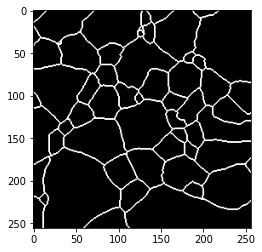

In [228]:
from skimage.segmentation import find_boundaries
watershed_boundaries = find_boundaries(labels)
plt.imshow(watershed_boundaries,cmap='gray')

watershed_boundaries = watershed_boundaries.astype(int)
skeleton = morphology.skeletonize(watershed_boundaries)
skel = 255 * skeleton
watershed_boundaries = skel

io.imsave(f'{test_dir}watershed_boundaries.png', watershed_boundaries.astype('uint8')) 

ground_truth = labelmake(trace) 
comparison_unclean = labelmake(gen)
comparison_clean = labelmake(watershed_boundaries)

chi2 = find_chi2(trace,gen)
chi2water = find_chi2(trace,watershed_boundaries)
randerr,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_unclean, ignore_labels=[0])
print(f'the processed rand error is {randerr}\n its chi2 is {chi2}')
randerr_water,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_clean, ignore_labels=[0])
print(f'the watershed rand error is {randerr_water}\n its chi2 is {chi2water}')

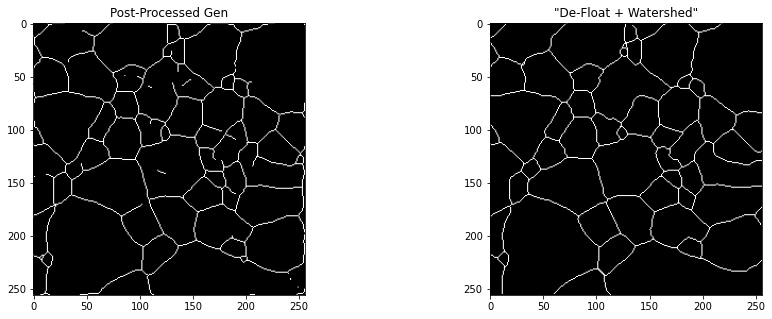

In [191]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize = (15,5))       

ax1.imshow(gen, cmap='gray') 
ax1.set_title('Post-Processed Gen')
ax2.imshow(watershed_boundaries, cmap='gray')
ax2.set_title('\"De-Float + Watershed\"')
plt.show()

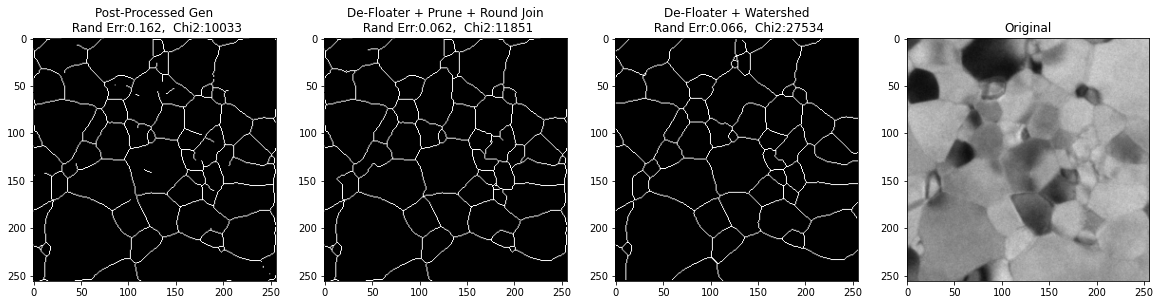

In [227]:
original_small = resize(original, (w, w), anti_aliasing=True)
fig, (ax1, ax2, ax3,ax4) = plt.subplots(ncols=4,figsize = (20,5))       

ax1.imshow(gen, cmap='gray')
ax1.set_title(f'Post-Processed Gen\n Rand Err:{round(randerr,3)},  Chi2:{chi2}')
ax2.imshow(fixed, cmap='gray')
ax2.set_title(f'De-Floater + Prune + Round Join\n Rand Err:{round(randerr_fixed,3)},  Chi2:{chi2fixed}')
ax3.imshow(watershed_boundaries, cmap='gray')
ax3.set_title(f'De-Floater + Watershed\n Rand Err:{round(randerr_water,3)},  Chi2:{chi2water}')
ax4.imshow(original_small,cmap='gray')
ax4.set_title('Original')
plt.show()

In [219]:
'''
def overlay(front,back,color): #Take two binary images and overlay the top in color
  transparency = np.zeros((h, w, 4))
  transparency[:,:,:3] = front
'''
#later

'\ndef overlay(front,back,color): #Take two binary images and overlay the top in color\n  transparency = np.zeros((h, w, 4))\n  transparency[:,:,:3] = front\n'

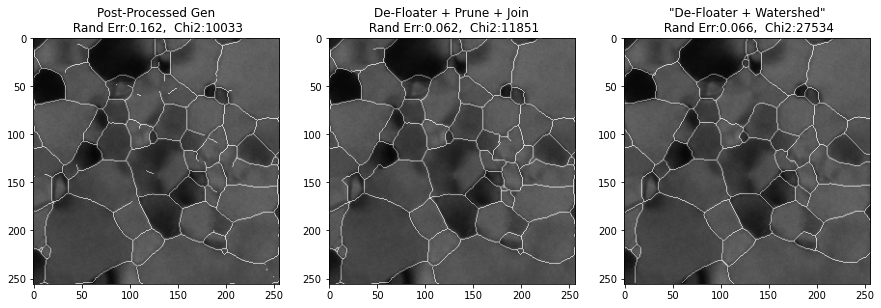

In [223]:
original_small = resize(original, (w, w), anti_aliasing=True)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize = (15,5))       

ax1.imshow(original_small,cmap='gray')
ax1.imshow(gen, cmap='gray',alpha=0.5)
ax1.set_title(f'Post-Processed Gen\n Rand Err:{round(randerr,3)},  Chi2:{chi2}')
ax2.imshow(original_small,cmap='gray')
ax2.imshow(fixed, cmap='gray',alpha=0.5)
ax2.set_title(f'De-Floater + Prune + Join\n Rand Err:{round(randerr_fixed,3)},  Chi2:{chi2fixed}')
ax3.imshow(original_small,cmap='gray')
ax3.imshow(watershed_boundaries, cmap='gray',alpha=0.5)
ax3.set_title(f'\"De-Floater + Watershed\"\n Rand Err:{round(randerr_water,3)},  Chi2:{chi2water}')

plt.show()

In [233]:
watershed_edit = mpimg.imread(f'{test_dir}watershed_boundaries_edited.png')

ground_truth = labelmake(trace) 
comparison_unclean = labelmake(gen)
comparison_clean = labelmake(watershed_boundaries)
comparison_edit = labelmake(watershed_edit)

chi2 = find_chi2(trace,gen)
chi2water = find_chi2(trace,watershed_boundaries)
chi2water_edit = find_chi2(trace,watershed_edit)

randerr,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_unclean, ignore_labels=[0])
print(f'the processed rand error is {randerr}\n its chi
2 is {chi2}')
randerr_water,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_clean, ignore_labels=[0])
print(f'the watershed rand error is {randerr_water}\n its chi2 is {chi2water}')
randerr_water_edit,p,r = adapted_rand_error(image_true=ground_truth, image_test=comparison_edit, ignore_labels=[0])
print(f'the edited watershed rand error is {randerr_water_edit}\n its chi2 is {chi2water_edit}')

#plt.imshow(watershed_edit,cmap='gray')

the processed rand error is 0.16241893820030306
 its chi2 is 10033
the watershed rand error is 0.06644813334591593
 its chi2 is 27534
the edited watershed rand error is 0.0707092601442485
 its chi2 is 25434
